Chargement du fichier data/matrice_routes_ordre.csv...

Paramètres du problème:
- Nombre de villes: 50
- Points de collecte: [9, 31]
- Taille de la matrice: (50, 50)
Gen 0: Best=925 Avg=925.0
Gen 10: Best=925 Avg=925.0
Gen 20: Best=925 Avg=925.0
Gen 30: Best=925 Avg=925.0
Gen 40: Best=925 Avg=925.0
Gen 50: Best=925 Avg=928.4
Gen 60: Best=925 Avg=925.0
Gen 70: Best=925 Avg=925.0
Gen 80: Best=925 Avg=925.0
Gen 90: Best=925 Avg=925.0
Gen 100: Best=925 Avg=925.0
Gen 110: Best=925 Avg=925.0
Gen 120: Best=925 Avg=926.3
Gen 130: Best=925 Avg=925.0
Gen 140: Best=925 Avg=925.0
Gen 150: Best=925 Avg=928.1
Gen 160: Best=925 Avg=925.0
Gen 170: Best=925 Avg=925.0
Gen 180: Best=925 Avg=930.7
Gen 190: Best=925 Avg=925.0

Optimisation terminée en 2.39s
Meilleur coût trouvé: 925
Solution valide: True


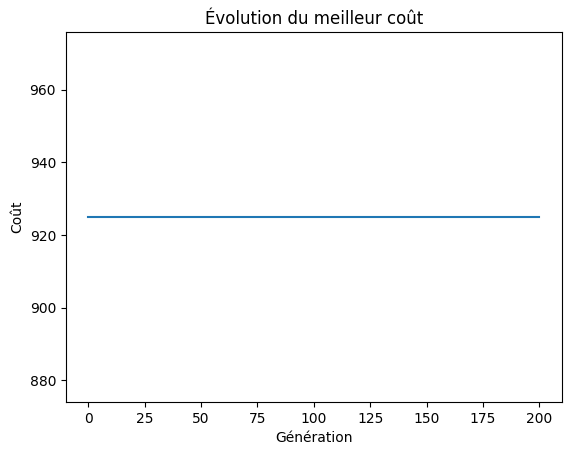


Meilleur chemin trouvé (extrait):
Départ: [1, 9, 16]...[40, 19, 1]
Longueur: 51 villes
Coût total: 925


In [3]:
import random
import numpy as np
from typing import List, Tuple, Set
import time
import matplotlib.pyplot as plt

def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        # Dernière ligne contient les points de collecte
        points_collecte = list(map(int, lines[-1].split(';')))
        
        # Matrice d'adjacence dans les autres lignes
        matrix = []
        for line in lines[:-1]:
            row = list(map(int, line.split(';')))
            matrix.append(row)
            
        return np.array(matrix), points_collecte
        
    except FileNotFoundError:
        raise ValueError(f"Fichier {file_path} introuvable")
    except Exception as e:
        raise ValueError(f"Erreur lors de la lecture du fichier: {str(e)}")

class GeneticTSP:
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []
        
        # Pré-calcul des villes accessibles depuis chaque ville
        self.accessible_from = {
            i: [j for j in range(1, self.num_cities+1) if matrix[i-1][j-1] != -1]
            for i in range(1, self.num_cities+1)
        }
        
        # Validation des entrées
        self._validate_inputs()
    
    def _validate_inputs(self):
        if len(self.matrix.shape) != 2 or self.matrix.shape[0] != self.matrix.shape[1]:
            raise ValueError("La matrice d'adjacence doit être carrée")
        if self.start_node < 1 or self.start_node > self.num_cities:
            raise ValueError(f"Le noeud de départ doit être entre 1 et {self.num_cities}")
        if not self.collecte:
            raise ValueError("Aucun point de collecte spécifié")

    def is_valid_path(self, path: List[int]) -> bool:
        """Vérifie si un chemin satisfait toutes les contraintes."""
        # Vérification basique
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
            
        # Points de collecte
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
            
        # Toutes villes visitées exactement une fois (sauf départ/arrivée)
        if len(set(path)) != self.num_cities:
            return False
            
        # Chemins valides
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
                
        return True

    def calculate_cost(self, path: List[int]) -> int:
        """Calcule le coût total d'un chemin."""
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _greedy_construction(self) -> List[int]:
        """Construit une solution initiale avec une approche gloutonne en respectant les contraintes."""
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        
        # Premier mouvement vers le point de collecte le plus proche
        collect_candidates = [c for c in self.collecte if c in unvisited and 
                            self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
            
        nearest_collect = min(collect_candidates, 
                            key=lambda x: self.matrix[self.start_node-1][x-1])
        path.append(nearest_collect)
        unvisited.remove(nearest_collect)
        
        # Construction gloutonne du chemin
        while unvisited:
            last = path[-1]
            
            # Filtrer les villes accessibles non visitées
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            
            if not candidates:
                # Si aucun candidat valide, essayer de trouver un chemin valide
                candidates = list(unvisited)
                random.shuffle(candidates)
                
            # Sélectionner la ville la plus proche accessible
            next_city = None
            min_dist = float('inf')
            for c in candidates:
                if self.matrix[last-1][c-1] < min_dist and self.matrix[last-1][c-1] != -1:
                    min_dist = self.matrix[last-1][c-1]
                    next_city = c
            
            if next_city is None:
                return None
                
            path.append(next_city)
            unvisited.remove(next_city)
        
        # Retour au point de départ
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
            
        path.append(self.start_node)
        
        return path if self.is_valid_path(path) else None

    def generate_initial_population(self, size: int) -> List[List[int]]:
        """Génère une population initiale diversifiée."""
        population = []
        
        # 1. Solutions gloutonnes variées
        for _ in range(size//2):
            sol = self._greedy_construction()
            if sol:
                population.append(sol)
        
        # 2. Solutions semi-aléatoires avec contraintes respectées
        while len(population) < size:
            path = [self.start_node]
            unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
            
            # Ajout d'un point de collecte en deuxième position
            collect_candidates = [c for c in self.collecte if c in unvisited and 
                                self.matrix[self.start_node-1][c-1] != -1]
            if not collect_candidates:
                break
                
            collect_point = random.choice(collect_candidates)
            path.append(collect_point)
            unvisited.remove(collect_point)
            
            # Construction aléatoire mais valide du chemin
            while unvisited:
                last = path[-1]
                candidates = [c for c in self.accessible_from[last] if c in unvisited]
                
                if not candidates:
                    break
                    
                next_city = random.choice(candidates)
                path.append(next_city)
                unvisited.remove(next_city)
            
            # Retour au départ si possible
            if unvisited or self.matrix[path[-1]-1][self.start_node-1] == -1:
                continue
                
            path.append(self.start_node)
            
            if self.is_valid_path(path):
                population.append(path)
        
        return population[:size]

    def tournament_selection(self, population: List[List[int]], tournament_size: int = 5) -> List[List[int]]:
        """Sélection par tournoi."""
        selected = []
        for _ in range(len(population)):
            participants = random.sample(population, min(tournament_size, len(population)))
            winner = min(participants, key=lambda x: self.calculate_cost(x))
            selected.append(winner)
        return selected

    def ordered_crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        """Croisement ordonné pour préserver les permutations valides."""
        size = len(parent1)
        start, end = sorted(random.sample(range(1, size-1), 2))
        
        def create_child(p1, p2):
            child = [None]*size
            child[0] = child[-1] = self.start_node
            
            # Copier le segment entre start et end
            child[start:end] = p1[start:end]
            
            # Remplir avec les villes de p2 dans l'ordre
            remaining = [city for city in p2 if city not in child[start:end]]
            ptr = 1
            for i in range(1, size-1):
                if child[i] is None:
                    child[i] = remaining[ptr-1]
                    ptr += 1
            return child
        
        child1 = create_child(parent1, parent2)
        child2 = create_child(parent2, parent1)
        
        # Validation des enfants
        valid_child1 = child1 if self.is_valid_path(child1) else parent1
        valid_child2 = child2 if self.is_valid_path(child2) else parent2
        
        return valid_child1, valid_child2

    def mutate(self, path: List[int], mutation_rate: float = 0.1) -> List[int]:
        """Mutation par échange de deux villes."""
        if random.random() > mutation_rate or len(path) <= 3:
            return path
            
        # On ne mute pas le départ, l'arrivée ou les points de collecte contraints
        mutable_positions = list(range(1, len(path)-1))
        if len(path) > 3:
            mutable_positions.remove(1)  # Ne pas muter le premier point de collecte
        if len(path) > 4:
            mutable_positions.remove(len(path)-2)  # Ne pas muter l'avant-dernier point
            
        if len(mutable_positions) < 2:
            return path
            
        i, j = random.sample(mutable_positions, 2)
        new_path = path.copy()
        new_path[i], new_path[j] = new_path[j], new_path[i]
        
        return new_path if self.is_valid_path(new_path) else path

    def solve(self, population_size: int = 100, generations: int = 200, 
             mutation_rate: float = 0.15, elite_size: int = 10):
        """Algorithme génétique principal."""
        start_time = time.time()
        
        # Initialisation
        population = self.generate_initial_population(population_size)
        if not population:
            raise ValueError("Impossible de générer une population initiale valide. " +
                           "Vérifiez les contraintes et la matrice d'adjacence.")
            
        population.sort(key=lambda x: self.calculate_cost(x))
        self.best_solution = population[0]
        self.best_cost = self.calculate_cost(population[0])
        self.cost_history.append(self.best_cost)
        
        # Évolution
        for gen in range(generations):
            # Sélection élitiste
            elites = population[:elite_size]
            
            # Sélection
            selected = self.tournament_selection(population)
            
            # Croisement
            offspring = []
            for i in range(0, len(selected)-1, 2):
                child1, child2 = self.ordered_crossover(selected[i], selected[i+1])
                offspring.append(child1)
                offspring.append(child2)
            
            # Mutation
            mutated = [self.mutate(child, mutation_rate) for child in offspring]
            
            # Nouvelle population
            population = elites + mutated
            population.sort(key=lambda x: self.calculate_cost(x))
            population = population[:population_size]
            
            # Mise à jour meilleure solution
            current_best = population[0]
            current_cost = self.calculate_cost(current_best)
            if current_cost < self.best_cost:
                self.best_solution = current_best
                self.best_cost = current_cost
            self.cost_history.append(self.best_cost)
            
            # Affichage progression
            if gen % 10 == 0:
                avg_cost = np.mean([self.calculate_cost(p) for p in population])
                print(f"Gen {gen}: Best={self.best_cost} Avg={avg_cost:.1f}")
        
        print(f"\nOptimisation terminée en {time.time()-start_time:.2f}s")
        print(f"Meilleur coût trouvé: {self.best_cost}")
        print(f"Solution valide: {self.is_valid_path(self.best_solution)}")
        
        # Visualisation
        plt.plot(self.cost_history)
        plt.title("Évolution du meilleur coût")
        plt.xlabel("Génération")
        plt.ylabel("Coût")
        plt.show()
        
        return self.best_solution, self.best_cost

# Exemple d'utilisation avec votre lecture de fichier
if __name__ == "__main__":
    try:
        file_path = "data/matrice_routes_ordre.csv"  # Remplacez par votre chemin
        print(f"Chargement du fichier {file_path}...")
        matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
        
        print("\nParamètres du problème:")
        print(f"- Nombre de villes: {len(matrix)}")
        print(f"- Points de collecte: {collecte}")
        print(f"- Taille de la matrice: {matrix.shape}")
        
        # Résolution
        solver = GeneticTSP(matrix, collecte)
        solution, cost = solver.solve(
            population_size=100,
            generations=200,
            mutation_rate=0.2,
            elite_size=10
        )
        
        print("\nMeilleur chemin trouvé (extrait):")
        print(f"Départ: {solution[:3]}...{solution[-3:]}")
        print(f"Longueur: {len(solution)} villes")
        print(f"Coût total: {cost}")
        
    except Exception as e:
        print(f"Erreur: {str(e)}")